# Assignment 3

**Submission deadlines:**

  - Tuesday groups: 22.04.2025
  - Friday groups: 18.04.2025

**Points:** Aim to get 10 points + 4 extra

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

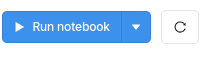

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

# Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flowers102` class; see [Flowers102.html](https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html). You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flowers102(root='./data', download=True, transform=transforms.ToTensor())
```

**Hint**: The default split of the dataset is 1020, 1020 and 6149 images for training, validation and test sets respectively.
If you can handle the bigger training dataset, you can experiment by taking up to 80% of the test set for training.


In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1. **[1p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    
* 2. **[2p]**:
    * Train your CNN on different training set sized (10%, 20%, 50%, 80%, 100%) and evaluate the performance on the validation set and test set.
        * Report the accuracy and loss on the validation set and test set for each training set size.
    * Train your CNN on the full training set plus 20%, 50% and 80% of the test set and evaluate the performance on the validation set and the remaining test set.
        * Report the accuracy and loss on the validation set and remaining test set for each training set size.
    * Compare the performance of your CNN on the different training set sizes and analyze the results.

* 3. **[1p]**:
    * Implement a baseline AlexNet model using PyTorch.
    * Training AlexNet may take a long time, so try to use GPU acceleration if available.

* 4. **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 5. **[2p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 6. **[2p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.
    * Experiment with different dropout rates and analyze their impact on the model's performance.

* 7. **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 8. ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

Use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

**[2p extra]**: present your findings (for each task) in a report format in Weight & Biases.




# Solution

### Start

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
import matplotlib.pyplot as plt
import wandb
import random
import torch.nn.functional as F
from IPython.display import clear_output
import torchvision.models as models

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maciej12ciepiela (maciej12cie) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

train_set = torchvision.datasets.Flowers102(root='./data', download=True, transform=transform_base)
valid_set = torchvision.datasets.Flowers102(root='./data', download=True, transform=transform_base, split='val')
test_set = torchvision.datasets.Flowers102(root='./data', download=True, transform=transform_base, split='test')
# print(train_set)
# print(valid_set)
# print(test_set)

100%|██████████| 345M/345M [00:20<00:00, 17.2MB/s]
100%|██████████| 502/502 [00:00<00:00, 989kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 25.5MB/s]


### Training functions

In [ ]:
def calculate_error(model, data_loader, device):
  model.eval()
  model.to(device)
  num_errs = 0.0
  num_examples = 0
  with torch.no_grad():
      for x, y in data_loader:
          x = x.to(device)
          y = y.to(device)
          outputs = model.forward(x)
          _, predictions = outputs.data.max(dim=1)
          num_errs += (predictions != y.data).sum().item()
          num_examples += x.size(0)
  return num_errs / num_examples

In [ ]:
def train_model(model, optimizer, data_loaders, num_epochs, device):
  val_error_history = []
  train_error_history = []
  for epoch in range(num_epochs):
      model.train()
      for inputs, labels in data_loaders['train']:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = model.loss(outputs, labels)
          loss.backward()
          optimizer.step()
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}", end=' ')

      val_error = calculate_error(model, data_loaders['valid'], device)
      val_error_history.append(val_error)
      train_error = calculate_error(model, data_loaders['train'], device)
      train_error_history.append(train_error)
      print(f"Validation Error: {100*val_error}% (train error: {100*train_error}% - for overfitting)")

      wandb.log({"epoch": epoch, "loss": loss.item(), "val_error": val_error, "train_error": train_error})
  test_error = calculate_error(model, data_loaders['test'], device)
  print(f"Test error: {100*test_error}%")
  return val_error_history, train_error_history, test_error


In [ ]:
batch_size = 128
data_loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test' : DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

### Problem 1

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=102):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

In [ ]:
wandb.init(project="a3-p1")
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
_,_,_ = train_model(model, optimizer, data_loaders, num_epochs, device)

### Problem 2

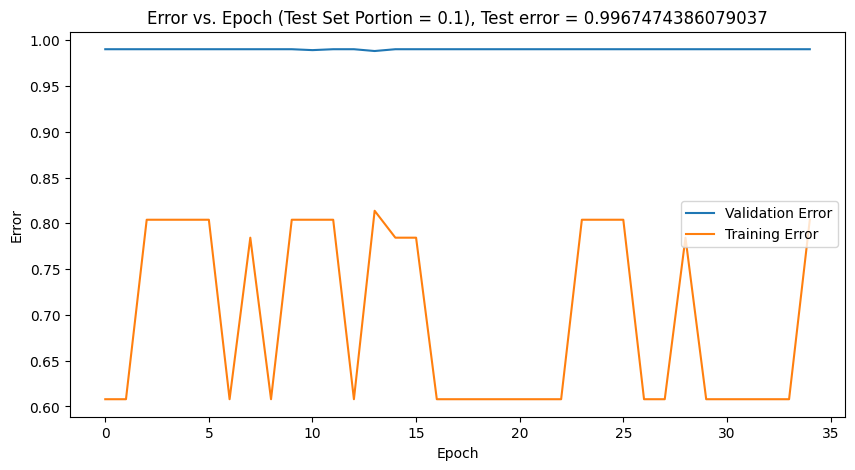

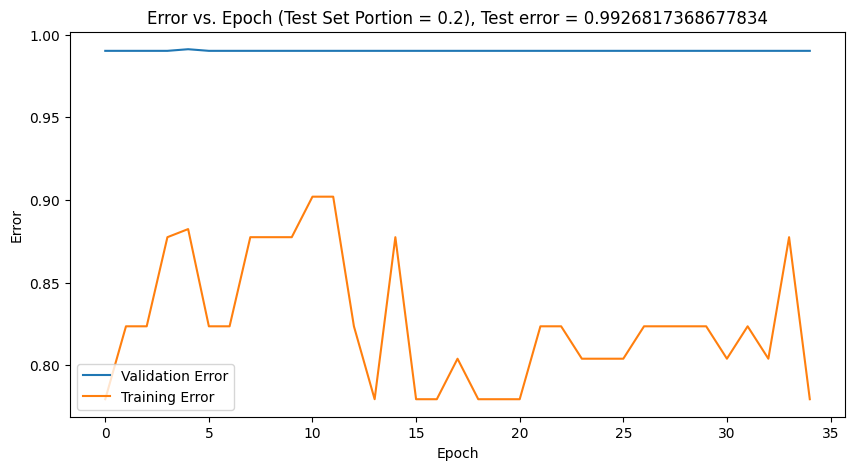

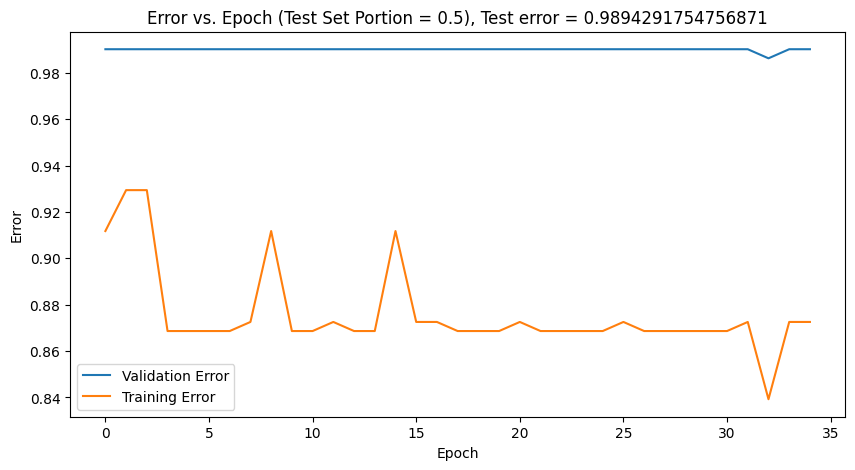

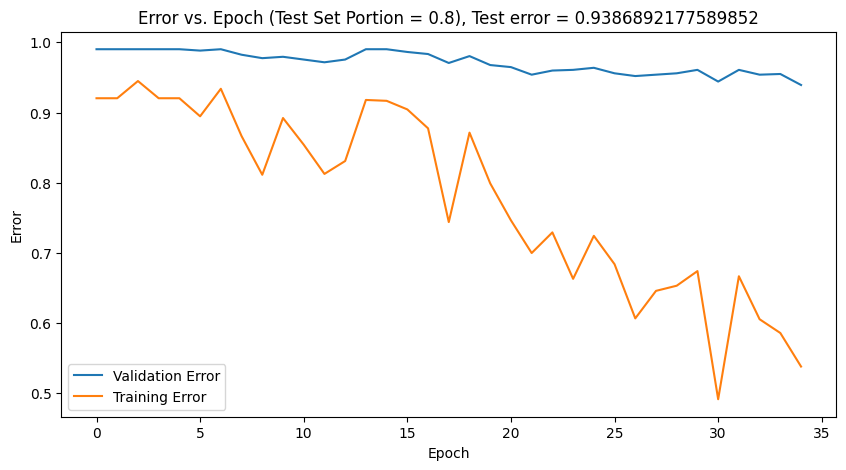

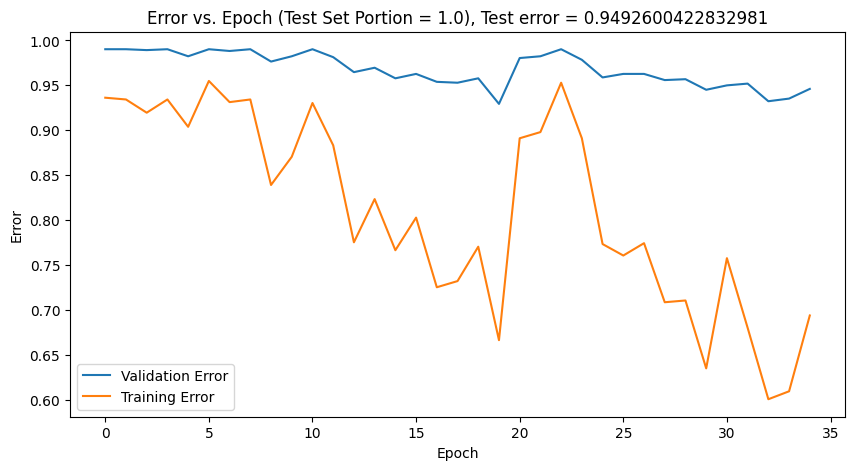

In [ ]:
results = {}
batch_size = 128
train_set_parts = [0.1, 0.2, 0.5, 0.8, 1.0]
for portion in train_set_parts:
    num_test_to_add = int(len(train_set) * portion)
    train_subset = Subset(test_set, indices=range(num_test_to_add))
    train_set_portion = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    wandb.init(project="a3-p2", config={"train_set_portion":portion})
    data_loaders = {'train':train_set_portion, 'valid':data_loaders['valid'], 'test':data_loaders['test']}
    model = CNN()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    num_epochs = 35
    model.to(device)

    print(f"Training with {portion*100}% of training set")
    val_err_history, train_err_history, test_error = train_model(model, optimizer, data_loaders, num_epochs, device)
    results[portion] = (model, val_err_history, train_err_history, test_error)
    clear_output(True)

for portion, (model, val_err_history, train_err_history, test_error) in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(val_err_history, label='Validation Error')
    plt.plot(train_err_history, label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'Error vs. Epoch (Test Set Portion = {portion}), Test error = {test_error}')
    plt.legend()
    plt.show()


In [ ]:
results = {}
test_set_portions = [0.2, 0.5, 0.8]
for portion in test_set_portions:
    num_test_to_add = int(len(test_set) * portion)
    test_subset_to_add = Subset(test_set, indices=range(num_test_to_add))

    combined_dataset = ConcatDataset([train_set, test_subset_to_add])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

    remaining_test_indices = list(range(num_test_to_add, len(test_set)))
    remaining_test_subset = Subset(test_set, indices=remaining_test_indices)
    remaining_test_loader = DataLoader(remaining_test_subset, batch_size=batch_size, shuffle=False)

    wandb.init(project="a3-p2", config={"test_set_portion":portion})
    data_loaders = {'train':combined_loader, 'valid':data_loaders['valid'], 'test':remaining_test_loader}
    model = CNN()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    num_epochs = 35
    model.to(device)

    print(f"Training with full training set + {int(num_test_to_add)} samples ({portion*100:.0f}% of test set)")
    val_err_history, train_err_history, test_error = train_model(model, optimizer, data_loaders, num_epochs, device)
    results[portion] = (model, val_err_history, train_err_history, test_error)
    clear_output(True)

for portion, (model, val_err_history, train_err_history, test_error) in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(val_err_history, label='Validation Error')
    plt.plot(train_err_history, label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'Error vs. Epoch (Test Set Portion = {portion}), Test error = {test_error}')
    plt.legend()
    plt.show()


### Problem 3

In [ ]:
class AlexNet(nn.Module):
        def __init__(self, num_classes=102):
            super(AlexNet, self).__init__()
            self.layers = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2),
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2),

                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2),

                nn.Flatten(),
                nn.Linear(6400, 4096),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(4096, num_classes))

        def forward(self, x):
            return self.layers(x)

        def loss(self, Out, Targets):
            return F.cross_entropy(Out, Targets)

In [ ]:
wandb.init(project="a3-p3")
batch_size = 128
data_loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test' : DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet = AlexNet()
alexnet = alexnet.to(device)
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
alexnet_res = train_model(alexnet, optimizer, data_loaders, 40, device)


### Problem 4

In [ ]:
transform_mean_subtraction = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[1, 1, 1])
])

transform_standardization = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set_mean_sub = torchvision.datasets.Flowers102(root='./data', download=True, transform=transform_mean_subtraction, split='train')
train_set_std = torchvision.datasets.Flowers102(root='./data', download=True, transform=transform_standardization, split='train')

data_loaders_mean_sub = {
    'train': DataLoader(train_set_mean_sub, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test' : DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

data_loaders_std = {
    'train': DataLoader(train_set_std, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test' : DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

data_loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test' : DataLoader(test_set, batch_size=batch_size, shuffle=False)
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wandb.init(project="a3-p4", config={"normalization_type":"mean_sub"})
model_mean_sub = AlexNet()
optimizer_mean_sub = optim.SGD(model_mean_sub.parameters(), lr=0.01)
model_mean_sub.to(device)
mean_sub_results = train_model(model_mean_sub, optimizer_mean_sub, data_loaders_mean_sub, 40, device)

wandb.init(project="a3-p4", config={"normalization_type":"std"})
model_std = AlexNet()
optimizer_std = optim.SGD(model_std.parameters(), lr=0.01)
model_std.to(device)
std_results = train_model(model_std, optimizer_std, data_loaders_std, 40, device)

wandb.init(project="a3-p4", config={"normalization_type":"none"})
baseline = AlexNet()
baseline = baseline.to(device)
optimizer = optim.SGD(baseline.parameters(), lr=0.01, momentum=0.9)
baseline_results = train_model(baseline, optimizer, data_loaders, 40, device)



Epoch 1/40, Loss: 4.627554893493652 Validation Error: 99.01960784313727% (train error: 99.11764705882354% - for overfitting)
Epoch 2/40, Loss: 4.623791694641113 Validation Error: 98.92156862745098% (train error: 99.2156862745098% - for overfitting)
Epoch 3/40, Loss: 4.626465797424316 Validation Error: 99.01960784313727% (train error: 99.01960784313727% - for overfitting)
Epoch 4/40, Loss: 4.623237133026123 Validation Error: 99.2156862745098% (train error: 98.33333333333333% - for overfitting)
Epoch 5/40, Loss: 4.62070894241333 Validation Error: 98.82352941176471% (train error: 97.45098039215686% - for overfitting)
Epoch 6/40, Loss: 4.623316287994385 Validation Error: 98.72549019607844% (train error: 97.45098039215686% - for overfitting)
Epoch 7/40, Loss: 4.62318229675293 Validation Error: 98.62745098039215% (train error: 97.05882352941177% - for overfitting)
Epoch 8/40, Loss: 4.623455047607422 Validation Error: 98.92156862745098% (train error: 96.76470588235294% - for overfitting)
Epoc

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇█▇▇▇▇▇▇▇▇█▇▇▇▆▇▆▇▇▆▆▆▅▆▆▆▆▇▅▆▅▆▄▄▄▅▂▁▂
train_error,███▇▆▆▅▅▅▄▄▄▄▄▄▃▃▂▂▂▁▁▂▁▂▂▂▁▁▁▁▂▂▃▄▄▅▅▄▄
val_error,▇▇▇█▇▇▆▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▅▅▄▆▅▃▃▁▂▂▂▁▂▂▂▃▃▃
epoch,39
loss,4.58956
train_error,0.96275
val_error,0.97255


Epoch 1/40, Loss: 4.6272993087768555 Validation Error: 99.01960784313727% (train error: 99.50980392156863% - for overfitting)
Epoch 2/40, Loss: 4.624380111694336 Validation Error: 99.01960784313727% (train error: 99.11764705882354% - for overfitting)
Epoch 3/40, Loss: 4.628665447235107 Validation Error: 99.01960784313727% (train error: 99.11764705882354% - for overfitting)
Epoch 4/40, Loss: 4.626722812652588 Validation Error: 99.2156862745098% (train error: 99.01960784313727% - for overfitting)
Epoch 5/40, Loss: 4.623452663421631 Validation Error: 99.2156862745098% (train error: 99.11764705882354% - for overfitting)
Epoch 6/40, Loss: 4.626948356628418 Validation Error: 99.31372549019608% (train error: 98.82352941176471% - for overfitting)
Epoch 7/40, Loss: 4.621585369110107 Validation Error: 99.50980392156863% (train error: 99.01960784313727% - for overfitting)
Epoch 8/40, Loss: 4.621597766876221 Validation Error: 99.70588235294117% (train error: 98.92156862745098% - for overfitting)
E

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▇▆▇▆▇▆▅▅▆▄▄▄▂▁▂▁
train_error,█▇▇▆▇▆▆▆▅▆▅▄▄▃▄▂▂▂▂▂▂▁▂▁▁▁▁▂▂▂▂▂▃▃▂▃▃▃▃▃
val_error,▃▃▃▄▄▅▆▇▆▄▅▅▄▃▄▄▅▄▅▅▇▆▇█▇▇▆▆▃▄▄▄▄▅▁▂▃▃▃▃
epoch,39
loss,4.57703
train_error,0.97941
val_error,0.9902


Epoch 1/40, Loss: 4.6280059814453125 Validation Error: 99.01960784313727% (train error: 99.01960784313727% - for overfitting)
Epoch 2/40, Loss: 4.624775409698486 Validation Error: 99.11764705882354% (train error: 99.11764705882354% - for overfitting)
Epoch 3/40, Loss: 4.623745441436768 Validation Error: 99.01960784313727% (train error: 99.01960784313727% - for overfitting)
Epoch 4/40, Loss: 4.619626045227051 Validation Error: 98.4313725490196% (train error: 98.0392156862745% - for overfitting)
Epoch 5/40, Loss: 4.612979888916016 Validation Error: 98.23529411764706% (train error: 97.94117647058823% - for overfitting)
Epoch 6/40, Loss: 4.604826927185059 Validation Error: 96.66666666666667% (train error: 96.37254901960785% - for overfitting)
Epoch 7/40, Loss: 4.574380397796631 Validation Error: 97.25490196078431% (train error: 97.15686274509804% - for overfitting)
Epoch 8/40, Loss: 4.524484157562256 Validation Error: 97.94117647058823% (train error: 96.86274509803921% - for overfitting)
E

In [ ]:
print(f"Test error for:\n -mean sub: {mean_sub_results[2]}\n -std: {std_results[2]}\n -base: {baseline_results[2]}")
plt.figure(figsize=(10, 5))
plt.plot(mean_sub_results[0], label='mean subtraction')
plt.plot(std_results[0], label='standardization')
plt.plot(baseline_results[0], label='baseline')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title(f'Validation error vs. epoch')
plt.legend()
plt.show()

### Problem 5

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [64, 128, 256]
optimizers = [optim.SGD, optim.Adam]
results = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"Experiment: lr={lr}, batch_size={batch_size}, optimizer={opt.__name__}")
            wandb.init(project="a3-p5", config={
                "learning_rate": lr,
                "batch_size": batch_size,
                "optimizer": opt.__name__
            })
            data_loaders = {
                'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
                'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
                'test': DataLoader(test_set, batch_size=batch_size, shuffle=False)
            }
            model = AlexNet()
            optimizer = opt(model.parameters(), lr=lr)
            num_epochs = 30
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            val_err_history, train_err_history, test_error = train_model(model, optimizer, data_loaders, num_epochs, device)
            results[(lr, batch_size, opt.__name__)] = (model, val_err_history, train_err_history, test_error)

for params, results in results.items():
    print(f"Test error for lr={params[0]}, batch_size={params[1]}, optimizer={params[2]}: {results[3]}")
    plt.figure(figsize=(10, 5))
    plt.plot(results[1], label='Validation Error')
    plt.plot(results[2], label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'Error vs. Epoch (lr={params[0]}, batch_size={params[1]}, optimizer={params[2]})')
    plt.legend()
    plt.show()

### Problem 6

In [ ]:
class NewCNN(nn.Module):
    def __init__(self, num_classes=102, p_dropout=0.5):
        super(NewCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

In [ ]:
batch_size = 128
data_loaders = {
                'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
                'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
                'test': DataLoader(test_set, batch_size=batch_size, shuffle=False)
            }
dropout_rates = [0.1, 0.3, 0.5, 0.7]
results = {}

for p_dropout in dropout_rates:
    print(f"Experiment: dropout_rate={p_dropout}")
    wandb.init(project="a3-p6", config={"dropout_rate": p_dropout})
    model = NewCNN(p_dropout=p_dropout)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    num_epochs = 35
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_err_history, train_err_history, test_error = train_model(model, optimizer, data_loaders, num_epochs, device)
    results[p_dropout] = (model, val_err_history, train_err_history, test_error)
    clear_output(True)

for p_dropout, results in results.items():
    print(f"Test error for dropout_rate={p_dropout}: {results[3]}")
    plt.figure(figsize=(10, 5))
    plt.plot(results[1], label='Validation Error')
    plt.plot(results[2], label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'Error vs. Epoch (dropout_rate={p_dropout})')
    plt.legend()
    plt.show()

NameError: name 'DataLoader' is not defined

### Problem 7

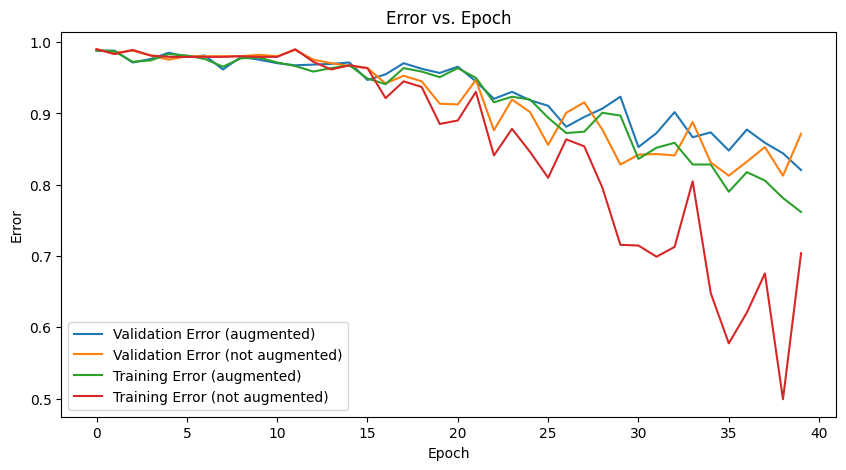

In [ ]:
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
])

train_set_augmented = torchvision.datasets.Flowers102(root='./data', download=True, transform=transform_augmented)
batch_size = 64
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_loaders_augmented = {
    'train': DataLoader(train_set_augmented, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

data_loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_set, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

wandb.init(project="a3-p7", config={"data_augmentation": "True"})
model_augmented = AlexNet()
optimizer_augmented = optim.SGD(model_augmented.parameters(), lr=0.1)
model_augmented.to(device)
augmented_results = train_model(model_augmented, optimizer_augmented, data_loaders_augmented, num_epochs, device)

clear_output(True)

wandb.init(project="a3-p7", config={"data_augmentation": "False"})
model = AlexNet()
optimizer = optim.SGD(model.parameters(), lr=0.1)
model.to(device)
not_augmentes_results = train_model(model, optimizer, data_loaders, num_epochs, device)

clear_output(True)
print(f"Test error with augmentation: {augmented_results[2]}")
print(f"Test error without augmentation (baseline): {not_augmentes_results[2]}")

plt.figure(figsize=(10, 5))
plt.plot(augmented_results[0], label='Validation Error (augmented)')
plt.plot(not_augmentes_results[0], label='Validation Error (not augmented)')
plt.plot(augmented_results[1], label='Training Error (augmented)')
plt.plot(not_augmentes_results[1], label='Training Error (not augmented)')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title(f'Error vs. Epoch')
plt.legend()
plt.show()
